# Homography-based Ground Detection for a Mobile Robot Platform Using a Single Camera

Abstract - This paper presents a practical approach to ground
detection in mobile robot applications based on a monocular
sequence captured by an on-board camera. We formulate the
problem of ground plane detection as one of estimating the
dominant homography between two frames taken from the
sequence, and then design an efficient algorithm for the
estimation. In particular, we analyze a problem inherent to any
homography-based approach to the given task, and show how the
proposed approach can address this problem to a large degree.
Although not explicitly discussed, the proposed method can be
used to guide the maneuver of the robot, as the detected ground
plane can in turn be used in obstacle avoidance. 

## 1) Feature Detection and Matching

Harris Corner is suggested to independently detect features in both images.

The dissimilarity of feature points is proposed as: $$ D(p,p')= \sum_{-w \leq i, j \leq w}^{} = |I_2 (x+i.y+j)-I_1(x'+i, y'+j)| $$

Furthermore a local search is performed to account for possible variability in the corner detection. The following example implements the Harris Corner Detector and Feature Matching including forward and backward matching. To evalutate the performance of their proposed dissimilarity function, the often used sum of squared differences and the normalized cross-correlation is also shown.

In [484]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import copy
from numba import jit, double,int_
import math 
import random

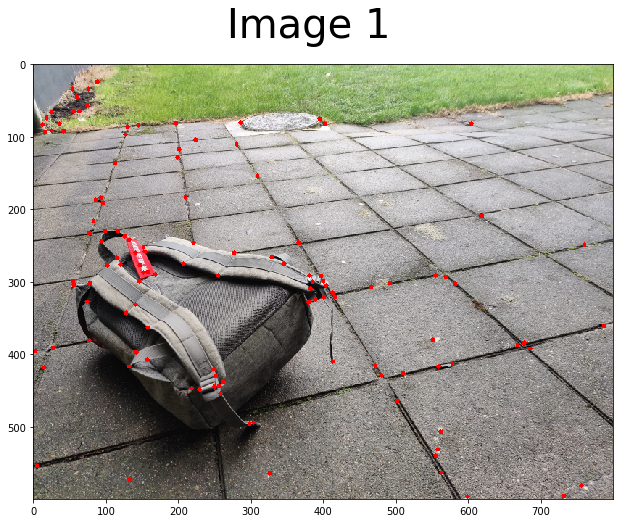

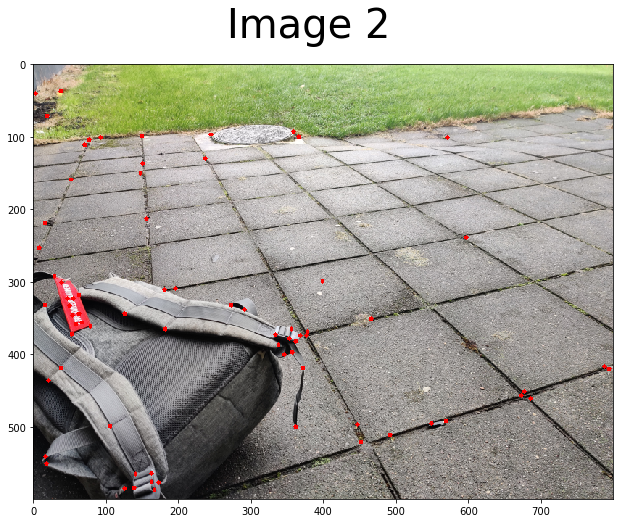

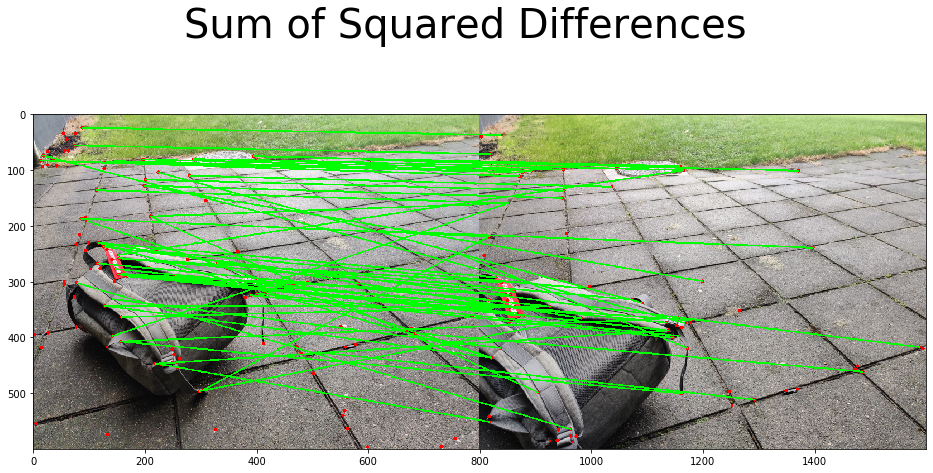

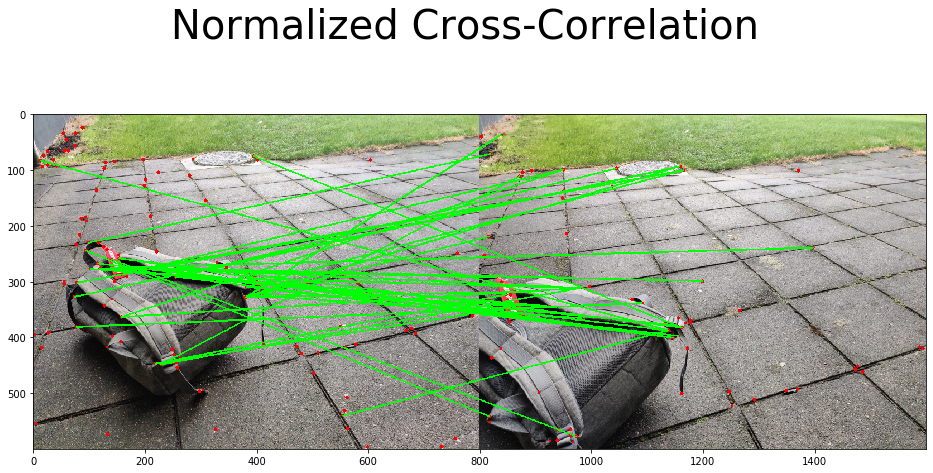

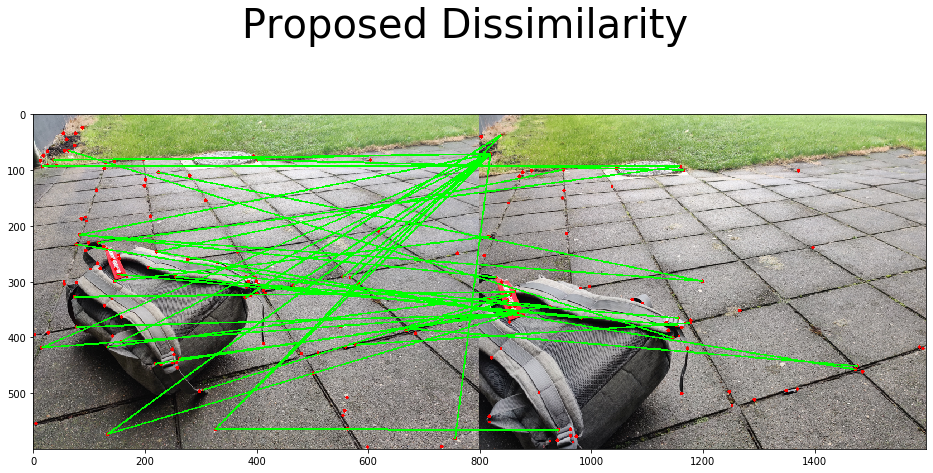

In [485]:
#Normalized Cross Coralation
def correlation_coefficient(window1, window2):
    product = np.mean((window1 - window1.mean()) * (window2 - window2.mean()))
    stds = window1.std() * window2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product
    
#Windows size and resolution not mentioned in Paper
window_size_width = 10
window_size_height = window_size_width
lineThickness = 2

# Read, scale down and convert images to gray scale
img1 = cv2.cvtColor(cv2.imread('frame_2.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('frame_3.jpg'), cv2.COLOR_BGR2RGB)
dim = (800, 600)
img1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)
height, width, ch = img1.shape[::]
img2_copy = img2.copy()
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#Detect Corners
dst1 = cv2.cornerHarris(gray1, 5, 7, 0.04)
dst2 = cv2.cornerHarris(gray2, 5, 7, 0.04)
ret1, dst1 = cv2.threshold(dst1, 0.05 * dst1.max(), 255, 0)
ret2, dst2 = cv2.threshold(dst2, 0.05 * dst2.max(), 255, 0)
dst1 = np.uint8(dst1)
dst2 = np.uint8(dst2)
ret1, labels1, stats1, centroids1 = cv2.connectedComponentsWithStats(dst1)
ret2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(dst2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners1 = cv2.cornerSubPix(gray1, np.float32(centroids1), (5, 5), (-1, -1), criteria)
corners2 = cv2.cornerSubPix(gray2, np.float32(centroids2), (5, 5), (-1, -1), criteria)
corners1 = np.int0(corners1)
corners2 = np.int0(corners2)


#Draw Corners
corners_windows1 = []
for i in corners1:
    x, y = i.ravel()
    cv2.circle(img1, (x, y), 3, 255, -1)

#Draw Corners
corners_windows2 = []
for i in corners2:
    x, y = i.ravel()
    cv2.circle(img2, (x, y), 3, 255, -1)

fig = plt.figure(figsize=(16,8))
fig.suptitle('Image 1', fontsize=40)
plt.imshow(img1), plt.show()
fig = plt.figure(figsize=(16,8))
fig.suptitle('Image 2', fontsize=40)
plt.imshow(img2), plt.show()


#Run Proposed Matching, Sum of Suared Differences and Normalized Cross Correlation
methods = ['Sum of Squared Differences', 'Normalized Cross-Correlation','Proposed Dissimilarity']
for method in methods:
    #list with id of matching 
    forward_matching_ids = []
    matches = []
    matches_src = []    
    matches_dst = []

    #Run over all corners in first image and find best match in second image
    for id1, i in enumerate(corners1):
        x1, y1 = i.ravel()
        #boundary condition
        if y1 - window_size_height > 0 and y1 + window_size_height < height and x1 - window_size_width > 0 and x1 + window_size_width < width:
            pt1 = (x1, y1)
            template = img1[y1 - window_size_height:y1 + window_size_height, x1 - window_size_width:x1 + window_size_width]
            max_val = 0
            Threshold = np.inf
            id_max = 0
            #Forward Matching
            for id2, i in enumerate(corners2):
                x2, y2 = i.ravel()
                #boundary condition
                if y2 - window_size_height > 0 and y2 + window_size_height < height and x2 - window_size_width > 0 and x2 + window_size_width < width:
                    window2 = img2[y2 - window_size_height:y2 + window_size_height, x2 - window_size_width:x2 + window_size_width]
                    if method == 'Proposed Dissimilarity':
                        temp_min_val = np.sum(np.abs(template - window2))
                    if method == 'Sum of Squared Differences':
                        temp_min_val = np.sum((template - window2) ** 2)
                    elif method == 'Normalized Cross-Correlation':
                        temp_min_val = correlation_coefficient(template, window2)
                    if temp_min_val < Threshold:
                        Threshold = temp_min_val
                        pt2 = (x2 + width, y2)                        
                        pt2_dst = (x2, y2)

                        temp_id2 = id2
                    
                    #Backward Matching
                    Threshold_backward = np.inf
                    for id1_backward, i in enumerate(corners1):
                        x1_backward, y1_abckward = i.ravel()
                        #boundary condition
                        if y1_abckward - window_size_height > 0 and y1_abckward + window_size_height < height and x1_backward - window_size_width > 0 and x1_backward + window_size_width < width:
                            window1_backward = img1[y1_abckward - window_size_height:y1_abckward + window_size_height, x1_backward - window_size_width:x1_backward + window_size_width]
                            if method == 'Proposed Dissimilarity':
                                temp_min_val = np.sum(np.abs(window2 - window1_backward))
                            if method == 'Sum of Squared Differences':
                                temp_min_val = np.sum((window2 - window1_backward) ** 2)
                            elif method == 'Normalized Cross-Correlation':
                                temp_min_val = correlation_coefficient(window2, window1_backward)
                            if temp_min_val < Threshold_backward:
                                Threshold_backward = temp_min_val
                                pt1_backward = (x1_backward + width, y1_abckward)
                                temp_id1_backward = id1_backward
                    
                    if id1 == temp_id1_backward:
                        matches.append((pt1, pt2))
                        matches_src.append(pt1)
                        matches_dst.append(pt2_dst)

                        forward_matching_ids.append((id1, temp_id2))
                        
    stacked_img = np.hstack((img1, img2))
    #show matches
    for match in matches[:]:
        matches[:]
        cv2.line(stacked_img, match[0], match[1], (0, 255, 0), lineThickness)
 
    
    fig = plt.figure(figsize=(16,8))
    fig.suptitle(method, fontsize=40)
    plt.imshow(stacked_img), plt.show()        

#### Comment: 
The Paramtreisation of Harris Corner was not mentioned and the boundary condaition for matching is also missing.
Harris Corner as a Feature Detector seems to be questionable looking at these results.

Furthermore the proposed dissimilarity function shows a bad performance an was outperformed a lot by the sum of squared differences. The quadratic penalizer seem to result in way better matches.


## 2) Homography Based Ground Detection

### Homography

The idea behind this approach is that in theory all ground points should share the same Homography between two views.

The Homography is defined as a transformation between two views: 

$$ x_i' = Hx_i $$

The matrix has 8 degrees of freedom and thus requires four non-degenerated point correspondances to be estimated

 ![Homography](https://docs.opencv.org/master/homography_transformation_example2.jpg)


### Ground detection based on dominant homograpy matrix 

The Problem of ground detection becomes estimating the dominant homography which accounts for the most feature points. Given a set of point correspondances, search for the dominant homography matrix that has most inliers.
To measure the the distance between in and outliers, the following distance function is beeing used: 

$$ d(x, x',H) ) = ||x' - Hx || $$

However it is not mentioned which norm is being used.

### Searching for the dominant homography

The authors propose an approach called "H-Clustering":

1. Initialize the outlier set to be all of the feature points
2. Randomly choose a point in the outlier set. Find its four closest points. Starting from these five points to repetitively compute H until the number of inliers converges. If the number of the inliers is less than 5, discard this H. Otherwise, create a cluster whose members are those inliers and remove these inliers from outliers set.
3. Repeat step 2 until the number of points in outliers set is less than 5.
4. Merge the clusters which have overlapping members. For each merging, use all of the points in both clusters as initial points set to repetitively compute H which is used to form a new cluster.

The following implemenations shows the basic components of the proposed "H-Clustering" algorithms. However due to the bad features and the even worse performing matching function, the "H-Clustering" shows no usuable output in this case. Merging the clusters is not even needed because so few clusters are actually valid.

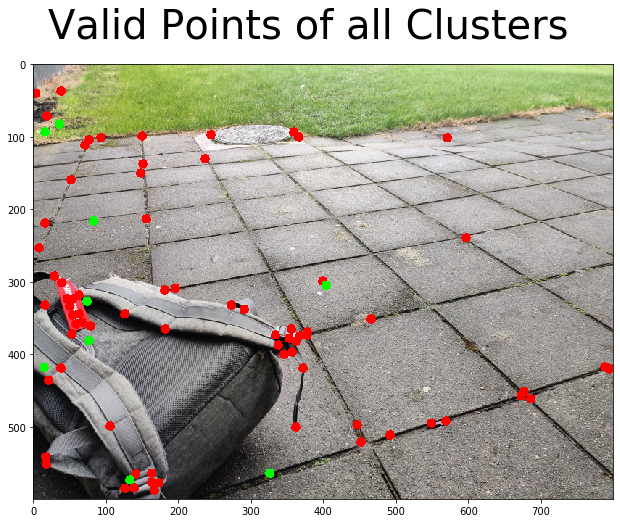

(<matplotlib.image.AxesImage at 0x1f79dd6de48>, None)

In [488]:
outlier_src = copy.deepcopy(matches_src)
outlier_dst = copy.deepcopy(matches_dst)
valid_src = []
valid_dst = []


while len(outlier_src) >= 8:
    inlier_src = []
    inlier_dst = []
    elemets_1, elements_2 = np.shape(outlier_src)
    initial_point = outlier_src[random.randint(0, elemets_1-1)]
    inlier_src.append(initial_point)
    inlier_dst.append(initial_point)
    #create new cluster
    for i in range(5):
        closest_point = np.inf
        for element_id, element in enumerate(outlier_src):
            #euclidian distance
            distance = math.sqrt((element[0]-initial_point[0])**2 + (element[1]-initial_point[1])**2)
            if(distance != 0):
                if distance < closest_point:
                    closest_point = distance
                    closest_point_id = element_id
        #add closest point to inliers and delete them from the outlier list
        inlier_src.append(outlier_src[closest_point_id])
        inlier_dst.append(outlier_dst[closest_point_id])
        del outlier_src[closest_point_id]
        del outlier_dst[closest_point_id]
    #use CV2 method in order to estimate the homography matrix and find outliers <-- the paper doesn't specify it
    M, mask = cv2.findHomography(np.float32(inlier_src).reshape(-1,1,2), np.float32(inlier_dst).reshape(-1,1,2), cv2.LMEDS ,5.0)
    #only add cluster with at least 5 valid values to to the valid cluster list
    if(np.count_nonzero(mask) > 4):
        valid_src.extend(inlier_src)
        valid_dst.extend(inlier_dst)

valid_src = np.squeeze(valid_src)
height, width = np.shape(valid_src)
    

#Draw Valid Cluster Points
img2_detected = copy.deepcopy(img2_copy)
for id, i in enumerate(corners2):
    x, y = i.ravel()
    cv2.circle(img2_detected, (x, y), 3, (255, 0, 0), 5)
for i in range(len(valid_src)):
    cv2.circle(img2_detected, (tuple(valid_src[i])), 3, (0, 255, 0), 5)

fig = plt.figure(figsize=(16,8))
fig.suptitle('Valid Points of all Clusters', fontsize=40)
plt.imshow(img2_detected), plt.show() 

#### Initial classification based on color
The test data used here shows very nicely why a classification based on color is a bad idea. The backpack which represents the obstacle has a similar color. Furthermore the gras on the same ground plane has a different color. The probability that virtual ground planes can be avoided by color segmentation is not a practical solution.

#### RANSAC:

For comparison a RANSAC approach to find the dominant homography is shown below. The authors claim it to be inappropriate because of the unpredictable runtime.

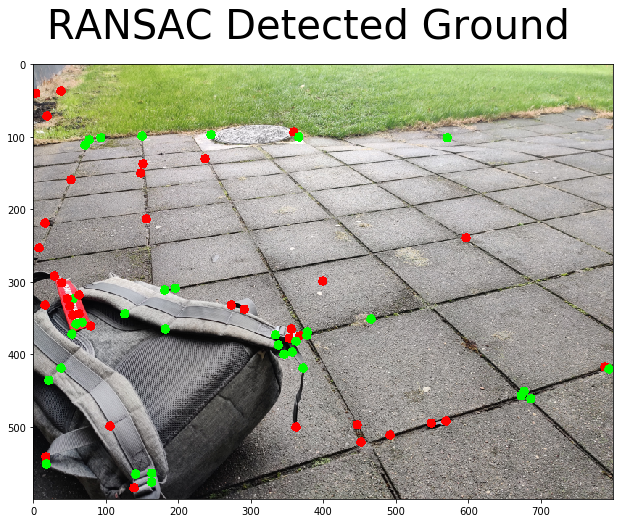

(<matplotlib.image.AxesImage at 0x1f79e0bda58>, None)

In [489]:
#RANSAC implementation which the authors claim to be inappropiate
M, mask = cv2.findHomography(np.float32(matches_src).reshape(-1,1,2), np.float32(matches_dst).reshape(-1,1,2), cv2.RANSAC ,50.0)

outlier = np.where(mask == 0)[0]
ground = np.where(mask == 1)[0]

img2_detected = copy.deepcopy(img2_copy)
#Draw Ground
for id, i in enumerate(corners2):
    x, y = i.ravel()
    if id in ground[:]:
        cv2.circle(img2_detected, (x, y), 3, (0, 255, 0), 5)
    if id in outlier[:]:
        cv2.circle(img2_detected, (x, y), 3, (255, 0, 0), 5)


fig = plt.figure(figsize=(16,8))
fig.suptitle('RANSAC Detected Ground', fontsize=40)
plt.imshow(img2_detected), plt.show()

#### Comment:

Both approaches show a very poor performance. Primarily caused by the poor selection of feautures in combination with unsuitable dissimilarity functions. Neither H-clustering nor RANSAC can find the dominant homography in this case, the majority of matches on the ground plane are wrong and are therefore sorted out as outliers. Only on the obstacle the Harris Corner features and the corresponding matches are good enough to be detected as inliers in the majority of cases.





But RANSAC even shows a much better performance then H-Clustering because it is not based on small clusters which are prone to errors. The ground detected by RANSAC has at least correctly identified wrong matches as outlier when comparing the green dots with the matches. However, the backpack has the majority of correct matches, so it is not possible to find the ground plane correctly.

For H-Clustering it looks even worse. The random initialization of the clusters causes that there are often too many wrong matches, so the homography estimation fails most of the time. This results in an almost useless result.

## 3) Proposed Alternative


## Better Features and Matching

It is unclear to me why the authors chose this bad combination of Harris-Corner and the presented dissimilarity function. The performance is poor and makes the rest of the work unnecessarily difficult. ORB or SIFT features in combination with a squared dissimilarity function (sum of squared differences) would probably have been much better.

## Optical Flow instead of Feature Matching 

Instead of ununique features and bad matches I would suggest to use global optical flow compared to the authors. This is also possible to calculate in realtime with multigrid solvers and solves the displacement field globally for each pixel with subpixel precision. To prove this assumption the simplest global optiocal flow method is implemented as following:

The Horn-Schunck algorithm assumes smoothness in the flow over the whole image. Thus, it tries to minimize distortions in flow and prefers solutions which show more smoothness. The flow is formulated as a global energy functional which is then sought to be minimized. This function is given for two-dimensional image streams as:

The data term penalises deviations from the brightness constancy assumption: $ (I_{x}u+I_{y}v+I_{t})^{2} $
The smoothness term penalises deviations from smoothness of the flow field, i.e. from variations of the functions given by their first derivatives: $ (\lVert \nabla u\rVert ^{2}+\lVert \nabla v\rVert ^{2}) $

The method of Horn and Schunck computes the optic flow as minimiser of the Euler Lagrange Equation:
$$ E=\iint \left[(I_{x}u+I_{y}v+I_{t})^{2}+\alpha ^{2}(\lVert \nabla u\rVert ^{2}+\lVert \nabla v\rVert ^{2})\right]{{{\rm {d}}}x{{\rm {d}}}y}$$




C:\Users\Bjarne\anaconda3\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-490-73dde572b2d0>", line 3:
@jit(nopython=True, parallel=True)
def update_step_single_jacobian(orig_size,u,v,u_old,v_old,alpha,J11,J22,J12,J13,J23,iterations):
^

  state.func_ir.loc))
C:\Users\Bjarne\anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'orig_size' of function 'update_step_single_jacobian'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-490-73dde572b2d0

Complteded to  10.001999999999999 %
Complteded to  20.003999999999998 %
Complteded to  30.006 %
Complteded to  40.007999999999996 %
Complteded to  50.01 %
Complteded to  60.012 %
Complteded to  70.014 %
Complteded to  80.01599999999999 %
Complteded to  90.018 %
Complteded to  100 %
ready


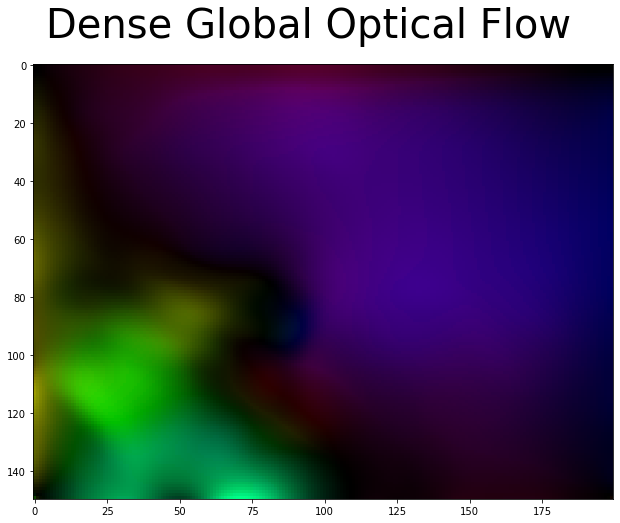

In [490]:
#use the most simple solver (Gauß-Seidel fixed point iteration) and therefore compensate runtime with numba
@jit(nopython=True, parallel=True)
def update_step_single_jacobian(orig_size,u,v,u_old,v_old,alpha,J11,J22,J12,J13,J23,iterations):
    nx = orig_size[0]
    ny = orig_size[1]
    bx = orig_size[2]
    by = orig_size[3]
    hx_2=alpha
    hy_2=alpha

    old_percent = 0.0
    for n in range(0,iterations):
        for i in range(bx,nx+bx): 
            for j in range(by,ny+by):
                #check for boundarie
                xp = (i<nx+bx-1) * hx_2
                xm = (i>bx) * hx_2
                yp = (j<ny+by-1) * hy_2
                ym = (j>by) * hy_2


                summe = - (xp + xm + yp + ym)

                u[i][j] = ( J13[i][j]+ J12[i][j] * v_old[i ][j ] \
                    - xm * u_old[i-1][j ] \
                    - xp * u_old[i+1][j ] \
                    - ym * u_old[i ][j-1] \
                    - yp * u_old[i ][j+1]) \
                    / ( summe - J11[i][j] )

                v[i][j] = ( J23[i][j] \
                    + J12[i][j] * u_old[i ][j ] \
                    - xm * v_old[i-1][j ] \
                    - xp * v_old[i+1][j ] \
                    - ym * v_old[i ][j-1] \
                    - yp * v_old[i ][j+1]) \
                    / ( summe - J22[i][j] )
        u_old = u
        v_old = v
        percent = (n/iterations ) * 100.0
        if (percent > old_percent+10.0):
            old_percent = percent
            print("Complteded to ", percent , "%")

    print("Complteded to ", 100 , "%")
    return u,v            
 
#Very simple implemenation of Horn & Schunck
class HundS:
    def __init__(self):
        self.J11 = None
        self.J22 = None
        self.J33 = None
        self.J12 = None
        self.J13 = None
        self.J23 = None
        self.fx = None
        self.fy = None
        self.ft = None
    
    #Gray value constancy assumptiom
    def compute_motion_tensor_grey_value_constancy(self,temp_img1,temp_img2,orig_size):
        #calc gradients
        #avg central difference
        nx = orig_size[0]
        ny = orig_size[1]
        bx = orig_size[2]
        by = orig_size[3]

        self.fx = np.zeros_like(temp_img1)
        self.fy = np.zeros_like(temp_img1)
        for i in range(bx,nx+bx): 
            for j in range(by,ny+by):
                self.fx[i,j] = 0.5*(temp_img1[i+1][j]-temp_img1[i-1][j]+temp_img2[i+1][j]-temp_img2[i-1][j])*0.5
                self.fy[i,j] = 0.5*(temp_img1[i][j+1]-temp_img1[i][j-1]+temp_img2[i][j+1]-temp_img2[i][j-1])*0.5
        self.ft = temp_img2 - temp_img1 #temporal gradient
        
        #structure tensor compoments
        self.J11 = self.fx * self.fx
        self.J22 = self.fy * self.fy
        self.J33 = self.ft * self.ft
        self.J12 = self.fx * self.fy
        self.J13 = self.fx * self.ft
        self.J23 = self.fy * self.ft

    #Gradient constancy assumptiom
    def compute_motion_tensor_gradient_constancy(self,temp_img1,temp_img2,orig_size):
        #calc gradients
        #avg central difference
        nx = orig_size[0]
        ny = orig_size[1]
        bx = orig_size[2]
        by = orig_size[3]

        fxx = np.zeros_like(temp_img1)
        fxy = np.zeros_like(temp_img1)
        fyy = np.zeros_like(temp_img1)
        fxt = np.zeros_like(temp_img1)
        fyt = np.zeros_like(temp_img1)
        for i in range(bx,nx+bx): 
            for j in range(by,ny+by):
                fxx[i][j] = ( self.fx[i+1][j ] - self.fx[i-1][j ] ) * 0.5
                fxy[i][j] = ( self.fx[i ][j+1] - self.fx[i ][j-1] ) * 0.5
                fyy[i][j] = ( self.fy[i ][j+1] - self.fy[i ][j-1] ) * 0.5
                fxt[i][j] = ( self.ft[i+1][j ] - self.ft[i-1][j ] ) * 0.5
                fyt[i][j] = ( self.ft[i ][j+1] - self.ft[i ][j-1] ) * 0.5

        
        #structure tensor compoments
        self.J11  = fxx *  fxx  +  fxy *  fxy 
        self.J22  = fxy *  fxy  +  fyy *  fyy 
        self.J33  = fxt *  fxt  +  fyt *  fyt 
        self.J12  = fxx *  fxy  +  fxy *  fyy 
        self.J13  = fxx *  fxt  +  fxy *  fyt 
        self.J23  =  fxy *  fxt  +  fyy *  fyt 

    def remove_padding(self,vec,orig_size):
        nx = orig_size[0]
        ny = orig_size[1]
        bx = orig_size[2]
        by = orig_size[3]
        retval = np.zeros((nx,ny))
        for i in range(nx):
            for j in range(ny):
                retval[i][j] = vec[i+bx][j+by]
        return retval
    #endfunf
    
    def calculate_hs_displacement(self, temp_img1 , temp_img2 , imgsmooting , iterations , alpha):
        #smooth image
        orig_size= [temp_img1.shape[0],temp_img1.shape[1]]
        orig_size.append(1)
        orig_size.append(1)


        #print("size factor: " , sizfac)

        temp_img1 = temp_img1.astype(float)
        temp_img2 = temp_img2.astype(float)
        if imgsmooting > 0:
            temp_img1 = cv.GaussianBlur(temp_img1, (0,0), imgsmooting)
            temp_img2 = cv.GaussianBlur(temp_img2, (0,0), imgsmooting)      
        
        #add border padding
        temp_img1 = cv.copyMakeBorder(temp_img1,1,1,1,1, cv.BORDER_CONSTANT,None,0)
        temp_img2 = cv.copyMakeBorder(temp_img2,1,1,1,1, cv.BORDER_CONSTANT,None,0)
        
        u = np.zeros_like(temp_img1)
        v = np.zeros_like(temp_img1)
        u_old = np.zeros_like(temp_img1)
        v_old = np.zeros_like(temp_img1)
        self.compute_motion_tensor_grey_value_constancy(temp_img1,temp_img2,orig_size)
        self.compute_motion_tensor_gradient_constancy(temp_img1,temp_img2,orig_size)

        u,v = update_step_single_jacobian(orig_size,u,v,u_old,v_old,alpha,self.J11,self.J22,self.J12,self.J13,self.J23,iterations)
        #remove border padding    
        u = self.remove_padding(u,orig_size)
        v = self.remove_padding(v,orig_size)
        print("ready")   

        return u,v


def show_displacement(temp_img1,u,v):
    hsv = np.zeros_like(img1)
    mag, ang = cv.cartToPolar(u,v)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    fig = plt.figure(figsize=(16,8))
    fig.suptitle('Dense Global Optical Flow', fontsize=40)
    plt.imshow(bgr), plt.show()   

# Read, scale down and convert images to gray scale
img1 = cv2.cvtColor(cv2.imread('frame_2.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('frame_3.jpg'), cv2.COLOR_BGR2RGB)
dim = (200, 150)
img1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)
height, width, ch = img1.shape[::]
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#calc displaceme
calculator = HundS()
u,v = calculator.calculate_hs_displacement(gray1, gray2, 6 , 50000 , 30)
show_displacement(gray1,u,v)

# 4) Conclusion

In summary, the paper makes me highly disagree and doubts the practicability of the presented approaches. First and most importantly, the Harris Corner features are only partially suitable as a basis due to the lack of uniquenes. Even the backward checking results in many wrong matches. Furthermore, the proposed dissimilarity function shows a very poor performance compared to long known approaches like the sum of squared differences. The square penalizer increases the robustness considerably, I don't understand why the authors didn't use it.

Furthermore, the authors claim that optical flow would not be suitable compared to Harris Corner because it is based on a local neighborhood. This statement is fundamental wrong. Dense Global Optical Flow solves this problem. The simplest and best known implementation (Horn & Schunck) already results in a dense displacement field, which can be used much better for ground detection. Advanced methods like "High Accuracy Optical Flow Estimation Based on a Theory for Warping" would be able to create a nearly error free displacement field. Compared to simple feature matching as presented in the paper, these global methods directly implement subpixel precision of the displacement. 

In addition, I disagree with the statement that RANSAC would be unsuitable due to the unpredictable runtime. Compared to the feature extraction and matching part, the runtime of RANSAC does not play a relevant role in the presented pipeline. The possibility to detect the outlier of all matches globally makes RANSAC very powerfull. Even with such bad data RANSAC could still detect the outlier correctly. H-Clustering failed catastrophically.

The described paper has 69 citations and was presented at the "IEEE International Conference on Robotics and Automation, ICRA 2006". All described methods existed at that time and the same criticism could have been made at that time. Overall, I do not see any added value in this paper, but simply a method that is worse than most of the alternatives, but just not published before.